# Spatial SIRS model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from blackbirds.models.spatial_sirs import SIRS
from blackbirds.infer import VI
from blackbirds.utils import soft_minimum, soft_maximum
from blackbirds.simulate import simulate_and_observe_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc

In [4]:
zeros = torch.zeros((4, 4))
idx = torch.randperm(16)[:4]
print(idx)
xs = idx // 4
ys = idx % 4
print(xs)
print(ys)
zeros[xs, ys] = 1
print(zeros)

tensor([13,  3,  6,  5])
tensor([3, 0, 1, 1])
tensor([1, 3, 2, 1])
tensor([[0., 0., 0., 1.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.]])


Following Dyer et al we fix

In [283]:
i0 = 0.02
n_timesteps = 100
N = 50

model = SIRS(n_timesteps=n_timesteps, i0=i0, N=N)

In [453]:
alpha = .6
beta = 0.4
gamma = 0.05

logit_alpha = np.log(alpha/(1-alpha))
logit_beta = np.log(beta/(1-beta))
logit_gamma = np.log(gamma/(1-gamma))

true_parameters = torch.tensor([logit_alpha, logit_beta, logit_gamma])
print(true_parameters)
# torch.manual_seed(0)
x = model.run(true_parameters)

true_data = model.observe(x)[0]

tensor([ 0.4055, -0.4055, -2.9444], dtype=torch.float64)


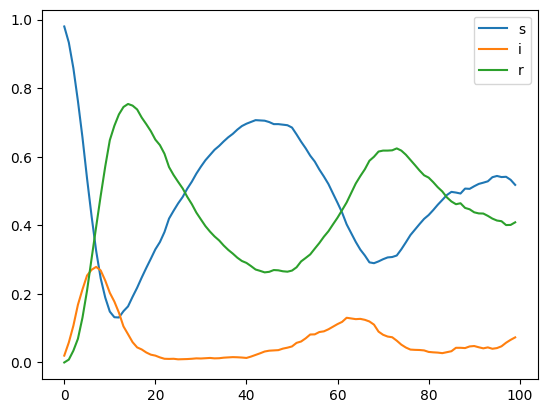

In [451]:
s_s, i_s, r_s = [], [], []
for t in range(n_timesteps):
    image = true_data[0, t, ...].numpy()
    s, i, r = (image == 0).mean(), (image == 1).mean(), (image == 2).mean()
    s_s.append(s)
    i_s.append(i)
    r_s.append(r)
plt.plot(s_s, label="s")
plt.plot(i_s, label="i")
plt.plot(r_s, label="r")
plt.legend()

sus = 0.2452; inf = 0.2684; rec = 0.4864


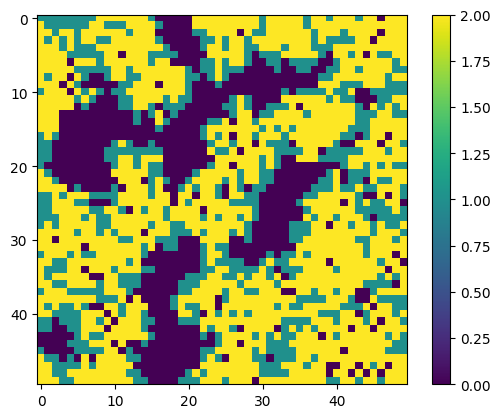

In [452]:
t = 8
image = true_data[0, t, ...].numpy()
print("sus = {0}; inf = {1}; rec = {2}".format((image == 0).mean(), (image == 1).mean(), (image == 2).mean()))
plt.imshow(image)
plt.clim(0,2)
plt.colorbar()

In [333]:
class IndependentLogNormals(torch.distributions.Distribution):
    
    def __init__(self, 
                 params,
                ):

        super().__init__()
        
        self.lognormals = [torch.distributions.LogNormal(mu, sigma) for (mu, sigma) in params]
        self._ndim = len(self.lognormals)
        
    def rsample(self, sample_shape):
        
        samples = [ln.rsample(sample_shape).reshape(-1, 1) for ln in self.lognormals]
        samples = torch.cat(samples, dim=-1)
        return samples
    
    def sample(self, sample_shape):
                
        samples = [ln.sample(sample_shape).reshape(-1, 1) for ln in self.lognormals]
        samples = torch.cat(samples, dim=-1)
        return samples
    
    def log_prob(self, values):
        
        if len(values.shape) == 1:
            values = values.unsqueeze(0)
            
        log_probs = torch.zeros_like(values)
        for i in range(self._ndim):
            log_probs += self.lognormals[i].log_prob(values[:, i])
        return log_probs
        
# prior = IndependentLogNormals([(0, 1) for i in range(3)])

In [578]:
mean = -0.5 * torch.ones(3)

prior = torch.distributions.MultivariateNormal(mean, 
                                               3*torch.eye(3))

In [615]:
prior_sample = prior.sample((1,))[0]
print(prior_sample)
x = model.run(prior_sample)
print(x.shape)

tensor([ 0.2842, -1.2276,  2.0284])
torch.Size([101, 50, 50])


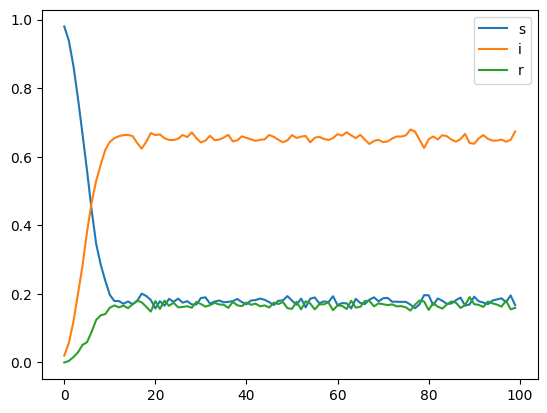

In [616]:
s_s, i_s, r_s = [], [], []
for t in range(n_timesteps):
    image = x[t, ...].numpy()
    s, i, r = (image == 0).mean(), (image == 1).mean(), (image == 2).mean()
    s_s.append(s)
    i_s.append(i)
    r_s.append(r)
plt.plot(s_s, label="s")
plt.plot(i_s, label="i")
plt.plot(r_s, label="r")
plt.legend()

#### LF-VI with DRE

In [209]:
import blackbirds.ratio_estimation as ratio_estimation
import blackbirds.networks as networks

import logging
logging.getLogger("ratio").setLevel(logging.INFO)

In [617]:
N_TOTAL = 1_000

In [685]:
dummy_out = torch.zeros_like(true_data[0]).unsqueeze(1)
print(dummy_out.shape)

for i in range(3):
    _dummy_out = torch.zeros_like(true_data[0])
    _dummy_out[(true_data[0] == i)] = 1
    _dummy_out = _dummy_out.unsqueeze(1)
    dummy_out = torch.cat((dummy_out, _dummy_out), dim=1)

dummy_out = dummy_out[:, 1:, ...]    

print(dummy_out.shape, dummy_out)

torch.Size([101, 1, 50, 50])
torch.Size([101, 3, 50, 50]) tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
       

In [694]:
def split_into_channels(simulation_output):
    
    dummy_out = torch.zeros_like(simulation_output).unsqueeze(1)

    for i in range(3):
        _dummy_out = torch.zeros_like(simulation_output)
        _dummy_out[simulation_output == i] = 1
        _dummy_out = _dummy_out.unsqueeze(1)
        dummy_out = torch.cat((dummy_out, _dummy_out), dim=1)

    dummy_out = dummy_out[:, 1:, ...].unsqueeze(0)
    return dummy_out

In [695]:
def simulator(theta):
    
    out = model.run(theta)
    
    # Keep everything in one channel
#     out = out.unsqueeze(1)
#     out = out.unsqueeze(0)

    # Split into 3 channels
    out = split_into_channels(out)
    return out

In [696]:
# SIMULATE TRAINING DATA
theta, x = ratio_estimation.generate_training_data(simulator, prior, n_training_samples=N_TOTAL)

In [706]:
n_summaries = 16
rnn_hidden_size = 16

linear_layer = torch.nn.Linear(rnn_hidden_size, n_summaries)

cnn_final_ff_sizes = [16, 16]

rnn = networks.RNN(input_size=cnn_final_ff_sizes[-1],
                          hidden_size=rnn_hidden_size,
                          num_layers=2,
                          final_ff=linear_layer,
                          flavour='gru'
                         )

summariser = networks.CNN_RNN(rnn,
                              N=N,
                              n_channels=x.size(2),
                              hidden_layer_channels=4,
                              conv_kernel_size=5,
                              pool_kernel_size=5,
                              final_ff=cnn_final_ff_sizes)

classifier = networks.MLP(input_dim=latent_size + n_summaries,
                          hidden_dims=[16, 16],
                          output_dim=1)

ratio_estimator = ratio_estimation.RatioEstimator(classifier_network=classifier, summary_network=summariser)

assert networks.count_pars(ratio_estimator) == networks.count_pars(classifier) + networks.count_pars(summariser)
assert networks.count_pars(ratio_estimator) > 0
print(networks.count_pars(ratio_estimator))

9921


In [707]:
# Normalise for training
x_normalised = x #/ N
# x_normalised = torch.cumsum(x, dim=1)
# x_normalised = x_normalised / x_normalised.max()
# summarised = summariser(x_normalised)
# print(summarised, summarised.shape)
# x_normalised = x_normalised[:, 1:, :]

In [708]:
theta_normalised = theta

In [ ]:
TRAIN_PROP = 0.8
N_TRAIN = int(TRAIN_PROP * N_TOTAL)
N_VAL = N_TOTAL - N_TRAIN

ratio_optimizer = torch.optim.Adam(ratio_estimator.parameters(), lr=5e-3)
ratio_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(ratio_optimizer, factor=0.5, patience=10)

best_ratio_estimator, loss_hist = ratio_estimation.train(x_normalised[:N_TRAIN],
                                                         theta_normalised[:N_TRAIN],
                                                         x_normalised[N_TRAIN:],
                                                         theta_normalised[N_TRAIN:],
                                                         ratio_estimator,
                                                         ratio_optimizer,
                                                         ratio_scheduler=ratio_scheduler,
                                                         max_iterations_without_val_loss_improvement=30,
                                                         max_num_epochs=1000
                                                        )

  0%|                                                                        | 1/1000 [00:11<3:17:15, 11.85s/it, train_loss=1.07, best_val_loss=1.13, current_val_loss=1.13, steps since last improvement=0]

In [644]:
len(loss_hist)

99

In [492]:
true_data.unsqueeze(2).shape

torch.Size([1, 101, 1, 50, 50])

In [702]:
estimator = make_flow()

# _true_data = true_data.unsqueeze(2)

_true_data = split_into_channels(true_data[0])

sy = best_ratio_estimator.sn_forward(_true_data)
sy = sy.detach().clone()

def ratio_nll(theta, y):
    
    ll = best_ratio_estimator.log_ratio(sy, theta)
    return -ll

loss = ratio_nll

optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
vi = VI(loss = loss, 
        posterior_estimator=estimator, 
        prior=prior, 
        optimizer=optimizer, 
        scheduler=scheduler,
        n_samples_per_epoch=100,
        w=1.,
        log_tensorboard=True,
        gradient_estimation_method="pathwise",
        gradient_clipping_norm=10.0,
        gradient_horizon=None
    )

vi.run(true_data.unsqueeze(2), n_epochs=1000, max_epochs_without_improvement=50);

 13%|███████████▏                                                                             | 126/1000 [00:10<01:14, 11.73it/s, loss=-1.8, reg.=4.15, total=2.35, best loss=1.85, epochs since improv.=50]


In [703]:
# We can load the best model to check the results
estimator.load_state_dict(vi.best_estimator_state_dict)

# Plot the final flow posterior approximator and compare it to the real parameters:
samples = estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

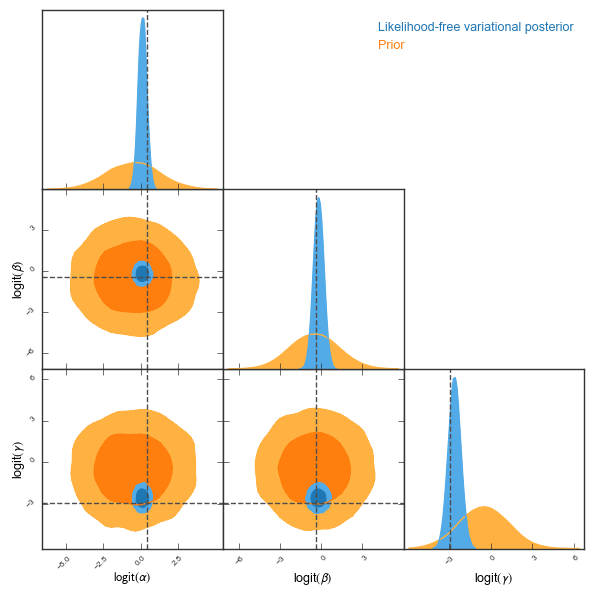

In [705]:
pygtc.plotGTC([samples, samples_prior], 
              figureSize=7, 
              truths = true_parameters.numpy(), 
              chainLabels = ["Likelihood-free variational posterior", "Prior"],
              paramNames = [r"$\mathrm{logit}(\alpha)$", r"logit$(\beta)$", r"logit$(\gamma)$"],);

plt.savefig("./vi4abms/likelihood_free/spatial_sirs.pdf", format='pdf', dpi=300, bbox_inches='tight')